# Snake

In [6]:
import environments_fully_observable 
#import environments_partially_observable
import numpy as np
import keras
from keras import layers
from  tqdm import trange
import matplotlib.pyplot as plt
import random
import tensorflow as tf
tf.random.set_seed(0)
random.seed(0)
np.random.seed(0)

## Environment definition

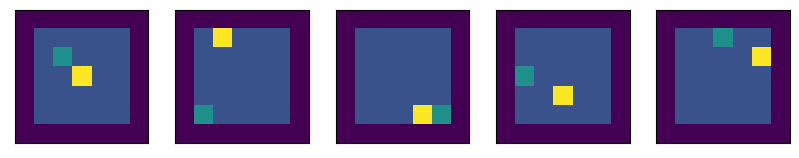

In [7]:
%matplotlib inline
# function to standardize getting an env for the whole notebook
def get_env(n):
    # n is the number of boards that you want to simulate parallely
    # size is the size of each board, also considering the borders
    # mask for the partially observable, is the size of the local neighborhood
    size = 7
    e = environments_fully_observable.OriginalSnakeEnvironment(n, size)
    # or environments_partially_observable.OriginalSnakeEnvironment(n, size, 2)
    return e
num_boards = 1000
env_ = get_env(num_boards)
GAMMA = .9
ITERATIONS = 10000

fig,axs=plt.subplots(1,min(len(env_.boards), 5), figsize=(10,3))
for ax, board in zip(axs, env_.boards):
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.imshow(board, origin="lower")

## Model

In [8]:
from tensorflow.keras import layers

def epsilon_greedy(q_values, epsilon):
    """
    Selects an action based on epsilon-greedy policy for a batch of tables.
    
    Args:
        q_values (numpy array): Q-values for each table and action. Shape: (num_tables, num_actions).
        epsilon (float): Probability of selecting a random action.
        
    Returns:
        actions: Selected actions indices. Shape: (num_tables,)
    """
    num_tables, num_actions = q_values.shape
    actions = np.zeros(num_tables, dtype=np.int32)
    for i in range(num_tables):
        if np.random.rand() < epsilon:
            # Choose a random action
            actions[i] = np.random.randint(num_actions)
        else:
            # Choose the action with the highest Q-value
            actions[i] = np.argmax(q_values[i])
    actions = actions.reshape(-1,1)
    return actions


class QEstimator(tf.keras.Model):
    def __init__(self, num_actions=4):
        super(QEstimator, self).__init__()
        self.conv1 = layers.Conv2D(32, (3, 3), input_shape=(7, 7, 4), activation='relu')
        self.conv2 = layers.Conv2D(64, (3, 3), activation='relu')
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(256, activation='relu')
        self.fc2 = layers.Dense(128, activation='relu')
        self.fc3 = layers.Dense(num_actions)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return self.fc3(x)

# Instantiate the models
q = QEstimator()
target_q = QEstimator()

## Training

In [9]:
optimizer = tf.keras.optimizers.legacy.Adam(1e-4)

# Replay buffer
replay_buffer = []

In [10]:
# Define the number of iterations, epsilon, and gamma
epsilon = 0.1
C = 10  # Update frequency for target network

cum_rewards = []  # Vector containing the mean of the rewards obtained in every iteration
prev_loss = float('inf')  # Early stopping if the loss does not improve after some iterations
count = 0  # Counter to track consecutive iterations with no improvement
early_stop = 10  # Number of consecutive iterations without improvement to trigger early stopping

# Define the main training loop
for iteration in trange(ITERATIONS, desc='Training', unit='iteration'):
    # Get current state of the boards
    state = env_.to_state()

    with tf.GradientTape(persistent=True) as tape:
        # Forward pass through the agent model to get Q-values
        q_values = q(state)

        # For each board, choose actions based on epsilon-greedy policy
        actions = epsilon_greedy(q_values, epsilon)
        
        # Perform a step in the environment
        rewards = env_.move(actions)
        new_state = tf.constant(env_.to_state())
        rewards = tf.squeeze(rewards)
        cum_rewards.append(np.mean(rewards))

        # Calculate the target Q-values using the Bellman equation
        target_q_values = rewards + GAMMA * tf.reduce_max(target_q(new_state), axis=1)

        # Compute the mean squared error loss
        loss = tf.reduce_mean(tf.square(target_q_values - tf.reduce_max(q_values, axis=1)))

    # Compute gradients
    gradients = tape.gradient(loss, q.trainable_variables)

    # Apply gradients
    optimizer.apply_gradients(zip(gradients, q.trainable_variables))

    # Update the target network every C steps
    if iteration % C == 0:
        target_q.set_weights(q.get_weights())

    # Check for early stopping
    if loss >= prev_loss:
        count += 1
        if count >= early_stop:
            print(f"No improvement in loss for {early_stopping_patience} consecutive iterations. Early stopping.")
            break
    else:
        count = 0

    prev_loss = loss
    #print(cum_rewards[iteration])
    #print(f"Iteration {iteration}: Loss = {loss.numpy()}")

# Save the trained model
q.save("trained_q_estimator")
#print("Cumulative rewards: ", cum_rewards)

Training:   0%|                                                                                                                                                        | 8/10000 [00:07<2:42:20,  1.03iteration/s]


KeyboardInterrupt: 

 ### Follow the fruit policy
 
This baseline strategy guides the snake toward the fruit by choosing the shortest and most efficient route. It ensures the snake avoids hitting the walls because the best way to get to the fruit doesn't involve crashing into them. 

In [32]:
def decide_move_direction(env_):
    state = env_.to_state()
    boards = env_.boards.astype(int)
    num_boards = state.shape[0]
    actions = []
    
    # Movement Costants
    UP = 0
    RIGHT = 1
    DOWN = 2
    LEFT = 3
    NONE = 4
    
    HEAD = 4
    BODY = 3
    FRUIT = 2
    EMPTY = 1
    WALL = 0
    
    for index in range(num_boards):
        curr_state = state[index]
        head_pos = np.where(curr_state[..., 3])  # Extract head positions
        fruit_pos = np.where(curr_state[..., 1])  # Extract fruit positions
        curr_board = boards[index]
        
        count = 0
        
        head_pos = (head_pos[0][0], head_pos[1][0])
        fruit_pos = (fruit_pos[0][0], fruit_pos[1][0])
        if abs(head_pos[0] - fruit_pos[0]) + abs(head_pos[1] - fruit_pos[1]) == 1:
            # If fruit is adjacent, calculate the direction towards the fruit
            if fruit_pos[0] < head_pos[0]:
                actions.append(DOWN)
            elif fruit_pos[0] > head_pos[0]:
                actions.append(UP)
            elif fruit_pos[1] < head_pos[1]:
                actions.append(LEFT)
            elif fruit_pos[1] > head_pos[1]:
                actions.append(RIGHT)
        else:
            # Else find all empty cells around the head
            walls_head = np.zeros(4)
            empty_cells_head = np.full((2, 4), 100, dtype = int)
            neighbor_offsets = [(0, -1), (-1, 0), (0, 1), (1, 0)]  # Left, Up, Right, Down

            # Check the cells around the head
            for offset in neighbor_offsets:
                neighbor_pos = (head_pos[0] + offset[0], head_pos[1] + offset[1])
                if curr_board[neighbor_pos[0], neighbor_pos[1]] == 1:
                    empty_cells_head[0][count] = neighbor_pos[0]
                    empty_cells_head[1][count] = neighbor_pos[1]
                    count = count + 1
                elif curr_board[neighbor_pos[0], neighbor_pos[1]] == 0:
                    walls_head[count] = 1
            #If there are no empty cells around the head identify the wall and choose that direction
            if np.all(empty_cells_head == 100) and np.any(walls_head):
                direction = np.nonzero(walls_head)[0]
                if direction == 0:
                    actions.append(LEFT)
                elif direction == 1:
                    actions.append(UP)
                elif direction == 2:
                    actions.append(RIGHT)
                elif direction == 3:
                    actions.append(DOWN)
            else:
                # Calculate distances from the empty cells to the fruit
                empty_cell_distances = np.abs(empty_cells_head[0] - fruit_pos[0]) + np.abs(empty_cells_head[1] - fruit_pos[1])

                # Find the empty cell nearest to the fruit
                min_distance_index = np.argmin(empty_cell_distances)

                # Select only the cells asjacent to the head of the snake
                nearest_empty_cell = (empty_cells_head[0][min_distance_index], empty_cells_head[1][min_distance_index])

                # Determine the direction to move based on the position of the nearest empty cell relative to the head
                if nearest_empty_cell[0] < head_pos[0]:
                    actions.append(DOWN)
                elif nearest_empty_cell[0] > head_pos[0]:
                    actions.append(UP)
                elif nearest_empty_cell[1] < head_pos[1]:
                    actions.append(LEFT)
                elif nearest_empty_cell[1] > head_pos[1]:
                    actions.append(RIGHT)

        
        
    
    actions = np.array(actions)      
    actions = actions.reshape(-1, 1)  
    return actions


 ### Plot of the game using the learnt policy
 

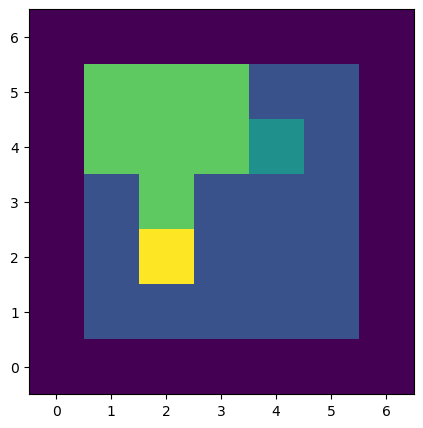

KeyboardInterrupt: 

In [49]:
from IPython.display import clear_output
import time

env_sim = get_env(1)
q = tf.saved_model.load('trained_q_estimator')
for iteration in range(200):
    state = env_sim.to_state()
    
    # Use the trained Q-network
    q_values = q(np.array(state))
    action = np.argmax(q_values)
    action = action.reshape(-1,1)
    
    rewards = env_sim.move(action)
    # Visualize the game board
    clear_output(wait=True)
    plt.figure(figsize=(5, 5))
    plt.imshow(env_sim.boards[0], origin="lower")
    plt.show()
    time.sleep(0.5)


 ### Plot of the game using the baseline policy
 

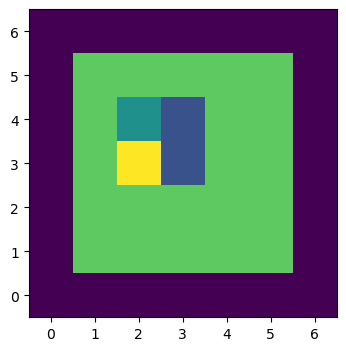

In [50]:
from IPython.display import clear_output
import time
env_sim = get_env(1)
for iteration in range(200):
    
    actions = decide_move_direction(env_sim)
    rewards = env_sim.move(actions)
    clear_output(wait=True)
    plt.figure(figsize=(4, 4))
    plt.imshow(env_sim.boards[0], origin="lower")
    plt.show()
    time.sleep(0.5)


 ### Random policy reward
 
Just a baseline (not the one you are supposed to develop)

In [33]:
random_env = get_env(num_boards)
random_rewards = []

for _ in trange(10000):
    probs = tf.convert_to_tensor([[.25]*4]*random_env.n_boards)
    #sample actions
    actions =  tf.random.categorical(tf.math.log(probs), 1, dtype=tf.int32)
    # MDP update
    rewards = random_env.move(actions)
    random_rewards.append(np.mean(rewards))
random_result = np.mean(random_rewards)
print(random_result)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:12<00:00, 52.01it/s]

-0.01446194


 ### Learnt policy reward
 

In [4]:
learnt_env = get_env(num_boards)
learnt_rewards = []
ITERATIONS = 1000
trained_q_estimator = tf.saved_model.load('trained_q_estimator')
actions = np.zeros(num_boards)

for iteration in trange(ITERATIONS):
    state = learnt_env.to_state()
    q_values = trained_q_estimator(state)
    actions = np.zeros(num_boards, dtype=np.int32)
    for i in range(num_boards):
        actions[i] = np.argmax(q_values[i])
    # Reshape actions values 
    actions = actions.reshape(-1,1)
    #q_values = q(np.array(state))
    
    # Apply the selected action
    rewards = learnt_env.move(actions)

    learnt_rewards.append(np.mean(rewards))
    
learnt_result = np.mean(learnt_rewards)
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:14<00:00,  1.48it/s]


 ### Follow the fruit policy reward


In [42]:
fruit_env = get_env(num_boards) 
fruit_rewards = []  # Vector to store rewards obtained for each board
ITERATIONS = 1000

for iteration in trange(ITERATIONS):
    actions = decide_move_direction(fruit_env)
    rewards = fruit_env.move(actions)
    fruit_rewards.append(np.mean(rewards))
fruit_result = np.mean(fruit_rewards)
print(fruit_result)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:10<00:00,  7.68it/s]

0.1027191


In [5]:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(cum_rewards, color='darkorange', label="Learnt Policy")
plt.axhline(y=fruit_result, color='r', linestyle='--', label="Baseline Policy")
plt.axhline(y=random_result, color='b', linestyle='--', label="Random Policy")
plt.title("Learning of The Agent")
plt.xlabel("Iterations")
plt.ylabel("Reward")
plt.legend()
plt.show()
plt.savefig('Training.jpg')
#print(learnt_result)
print(fruit_result)

0.13184759


NameError: name 'cum_rewards' is not defined

<Figure size 1000x500 with 0 Axes>

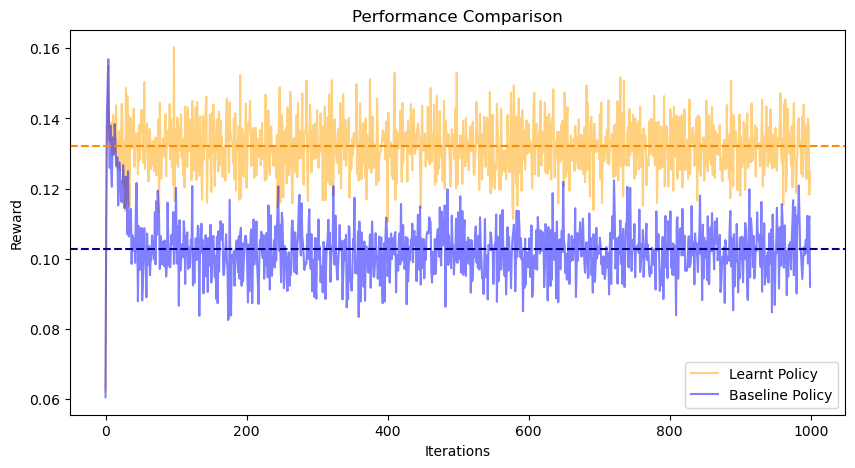

0.13206041
0.1027191


In [48]:
plt.figure(figsize=(10, 5))
plt.plot(learnt_rewards, color='orange', label="Learnt Policy", alpha=0.5)
plt.plot(fruit_rewards, color='blue', label="Baseline Policy", alpha=0.5)
plt.axhline(y=learnt_result, color='darkorange', linestyle='--')
plt.axhline(y=fruit_result, color='darkblue', linestyle='--')
plt.title("Performance Comparison")
plt.xlabel("Iterations")
plt.ylabel("Reward")
plt.legend()
plt.show()
print(learnt_result)
print(fruit_result)